In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = './data/surrModel_trainingDB_uF0_PS1_ss100k.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

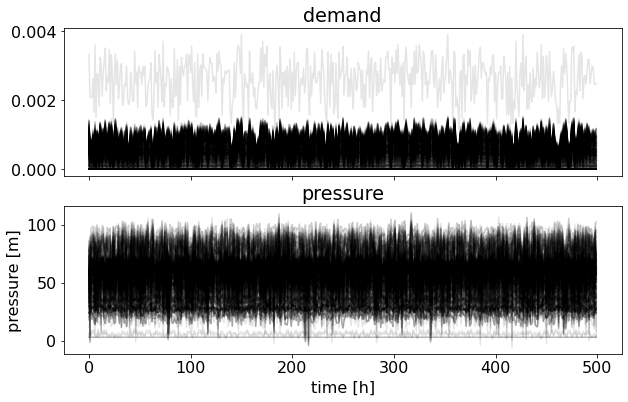

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

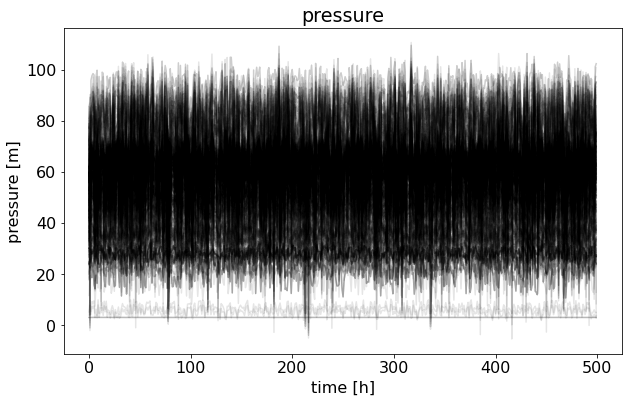

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'next tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

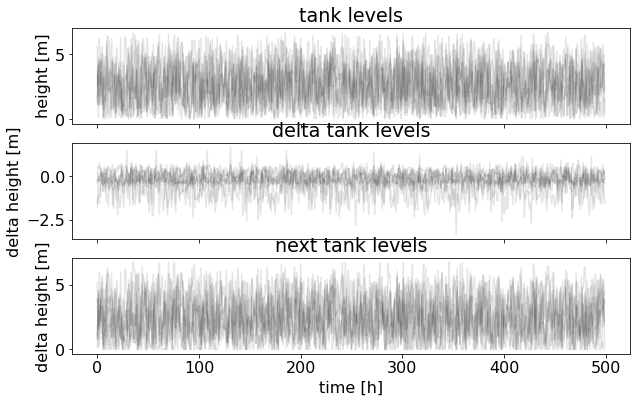

In [11]:
fig, ax = plt.subplots(3,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
dtank_level.columns = tank_level.columns
tank_level_next = tank_level+dtank_level
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')
tank_level_next.head(500).plot(ax=ax[2],legend=False, color='k', alpha=0.1, title='next tank levels', xlabel='time [h]', ylabel='delta height [m]')

In [12]:
100*(tank_level_next.mean()-tank_level.mean())/tank_level.mean()

T3    -1.690607
T1    -8.239207
T7   -27.415509
T6    -2.852221
T5    -8.000860
T2     7.004937
T4   -30.743406
dtype: float64

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

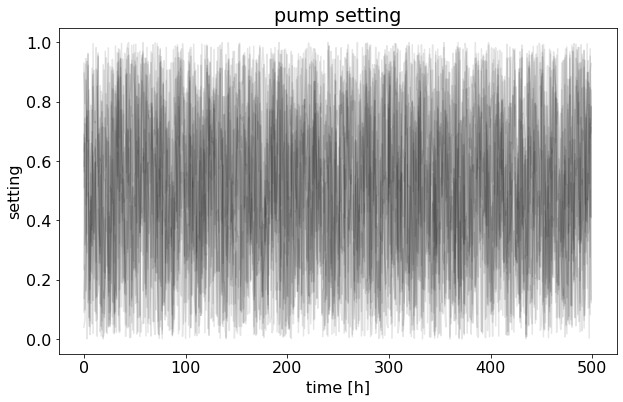

In [13]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

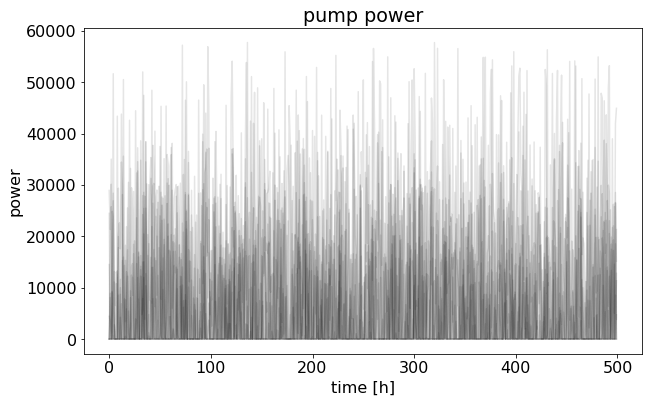

In [14]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [15]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

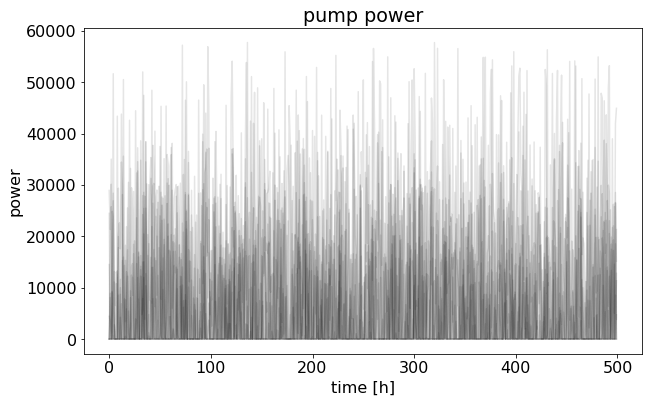

In [16]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

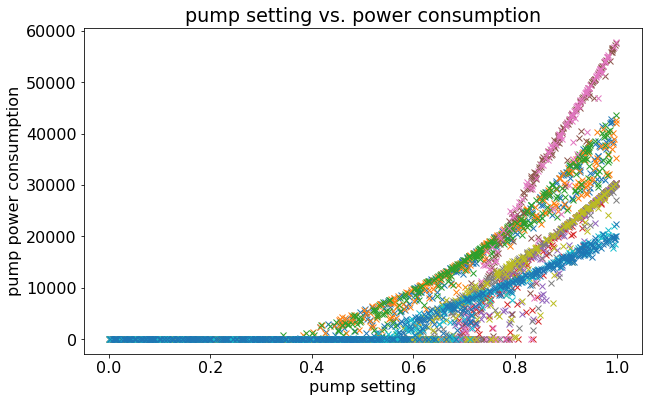

In [17]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

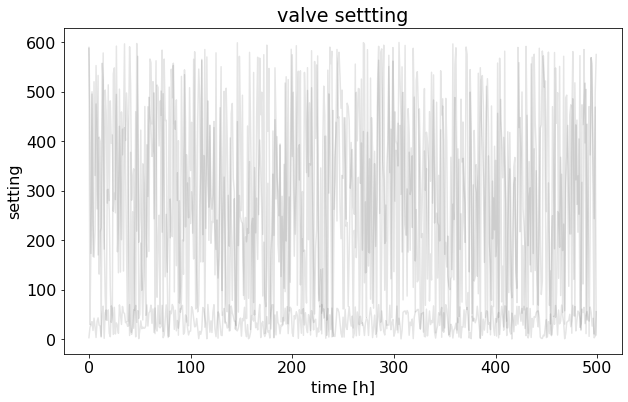

In [18]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [19]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000929  0.000762  0.000828    0.0    0.0  0.001107    0.0    0.0   
1        0.000587  0.000412  0.000447    0.0    0.0  0.000598    0.0    0.0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.001048  0.000913  ...     0.234480  0.040475  0.511187  0.564586   
1  0.000725  0.000631  ...     0.725745  0.064877  0.660430  0.889907   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.929807  0.583212  0.632190    589.815644  587.652053   2.766015  
1  0.098324  0.745180  0.679041    449.815104   29.166241  23.221929  

[2 rows x 409 columns]

### NN outputs:

In [25]:
output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'tank_level': dtank_level[data_filter],
    #'tank_level': tank_level_next[data_filter]
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         28.516209  63.541023  36.594948  58.643337  81.043335  33.113400   
1         31.023098  65.504532  38.143955  66.849159  89.249161  34.497074   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  32.755207  29.097137  48.912586  44.836769  ...  24463.834489     0.000000   
1  32.570992  28.920317  54.977676  50.884941  ...      0.000000  8904.443241   

                  dstates                                                    \
               tank_level                                                     
        PU11_P         T3        T1        T7        T6        T5        T2   
0  4406.649493  -0.414477 -0.194584 -1.587196 -0.258440  0.167841  0.520759   
1  3395.104302   0.031338 -0.311106 -0.220377  0.170594  0.423695  0.488421   

             
             
         T4  
0 -1.789435  
1 -1.130805  

[2 rows x 406 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [26]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


Split into test and train set:

In [27]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size = 0.1
)

In [28]:
input_scaling = nn_input_train.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_train_scaled = nn_input_train/input_scaling
nn_input_test_scaled = nn_input_test/input_scaling

output_scaling = nn_output_train.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_train_scaled = nn_output_train/output_scaling
nn_output_test_scaled = nn_output_test/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [29]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
unitnorm_cons = tf.keras.constraints.UnitNorm(
    axis=1
)

l1_penalty = tf.keras.regularizers.l1(l=0.0001)
l2_penalty = tf.keras.regularizers.l2(l=0.01)

In [63]:
n_cluster = 30
n_layer = 4
n_neurons_per_layer = 60

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=True,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    kernel_regularizer = None
    if i == 0:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_interm)
#         tf_interm = tf.keras.layers.Dropout(
#             .2,
#             name='interm_{}_dropout'.format(i)
#         )(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    #kernel_constraint=nonneg_cons,
    #kernel_constraint = unitnorm_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)


tf_out_3 = tf.keras.layers.Dense(
    nn_output['dstates'].shape[1], 
    name='dstates_out',
    #kernel_regularizer = l2_penalty,
)(tf_interm_2)

#tf_out_3 = tf.keras.layers.add([tf_out_3, tf_in_2], name='states_out')

In [64]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [65]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [66]:
x_subset = nn_input_train_scaled.head(50000)
y_subset = nn_output_train_scaled.head(50000)

x_train = [x_subset['demand'], x_subset['states'], x_subset['inputs']]
y_train = [y_subset['pressure'], y_subset['energy'], y_subset['dstates']]
x_test = [nn_input_test_scaled['demand'], nn_input_test_scaled['states'], nn_input_test_scaled['inputs']]
y_test = [nn_output_test_scaled['pressure'], nn_output_test_scaled['energy'], nn_output_test_scaled['dstates']]

history = model.fit(x_train, y_train,
                    batch_size=5000, 
                    epochs=1500)

Epoch 1/1500
10/10 [==============================] - 0s 38ms/step - loss: 0.8257 - pressure_out_loss: 0.5562 - energy_out_loss: 0.1177 - dstates_out_loss: 0.1518
Epoch 2/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.4986 - pressure_out_loss: 0.3347 - energy_out_loss: 0.0746 - dstates_out_loss: 0.0893
Epoch 3/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.2793 - pressure_out_loss: 0.1285 - energy_out_loss: 0.0673 - dstates_out_loss: 0.0835
Epoch 4/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.1840 - pressure_out_loss: 0.0402 - energy_out_loss: 0.0643 - dstates_out_loss: 0.0795
Epoch 5/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.1521 - pressure_out_loss: 0.0139 - energy_out_loss: 0.0629 - dstates_out_loss: 0.0753
Epoch 6/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.1402 - pressure_out_loss: 0.0077 - energy_out_loss: 0.0612 - dstates_out_loss: 0.0713
Epoch 7/1500
10/10 [==

10/10 [==============================] - 0s 45ms/step - loss: 0.0552 - pressure_out_loss: 0.0040 - energy_out_loss: 0.0206 - dstates_out_loss: 0.0306
Epoch 52/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0551 - pressure_out_loss: 0.0040 - energy_out_loss: 0.0206 - dstates_out_loss: 0.0305
Epoch 53/1500
10/10 [==============================] - 0s 43ms/step - loss: 0.0547 - pressure_out_loss: 0.0040 - energy_out_loss: 0.0204 - dstates_out_loss: 0.0303
Epoch 54/1500
10/10 [==============================] - 0s 46ms/step - loss: 0.0548 - pressure_out_loss: 0.0040 - energy_out_loss: 0.0204 - dstates_out_loss: 0.0304
Epoch 55/1500
10/10 [==============================] - 0s 44ms/step - loss: 0.0546 - pressure_out_loss: 0.0040 - energy_out_loss: 0.0204 - dstates_out_loss: 0.0302
Epoch 56/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0543 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0203 - dstates_out_loss: 0.0301
Epoch 57/1500
10/10 [=========

10/10 [==============================] - 1s 90ms/step - loss: 0.0441 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0163 - dstates_out_loss: 0.0244
Epoch 102/1500
10/10 [==============================] - 1s 54ms/step - loss: 0.0438 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0162 - dstates_out_loss: 0.0243
Epoch 103/1500
10/10 [==============================] - 0s 46ms/step - loss: 0.0434 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0160 - dstates_out_loss: 0.0240
Epoch 104/1500
10/10 [==============================] - 0s 43ms/step - loss: 0.0431 - pressure_out_loss: 0.0034 - energy_out_loss: 0.0159 - dstates_out_loss: 0.0239
Epoch 105/1500
10/10 [==============================] - 0s 42ms/step - loss: 0.0431 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0158 - dstates_out_loss: 0.0240
Epoch 106/1500
10/10 [==============================] - 0s 45ms/step - loss: 0.0430 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0157 - dstates_out_loss: 0.0239
Epoch 107/1500
10/10 [===

10/10 [==============================] - 0s 34ms/step - loss: 0.0290 - pressure_out_loss: 0.0027 - energy_out_loss: 0.0085 - dstates_out_loss: 0.0178
Epoch 151/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0286 - pressure_out_loss: 0.0027 - energy_out_loss: 0.0084 - dstates_out_loss: 0.0176
Epoch 152/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0284 - pressure_out_loss: 0.0026 - energy_out_loss: 0.0082 - dstates_out_loss: 0.0176
Epoch 153/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0281 - pressure_out_loss: 0.0026 - energy_out_loss: 0.0081 - dstates_out_loss: 0.0174
Epoch 154/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0281 - pressure_out_loss: 0.0026 - energy_out_loss: 0.0080 - dstates_out_loss: 0.0174
Epoch 155/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0278 - pressure_out_loss: 0.0026 - energy_out_loss: 0.0079 - dstates_out_loss: 0.0173
Epoch 156/1500
10/10 [===

10/10 [==============================] - 1s 59ms/step - loss: 0.0170 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0043 - dstates_out_loss: 0.0106
Epoch 200/1500
10/10 [==============================] - 1s 82ms/step - loss: 0.0166 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0042 - dstates_out_loss: 0.0103
Epoch 201/1500
10/10 [==============================] - 1s 79ms/step - loss: 0.0164 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0041 - dstates_out_loss: 0.0101
Epoch 202/1500
10/10 [==============================] - 0s 50ms/step - loss: 0.0162 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0041 - dstates_out_loss: 0.0101
Epoch 203/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0162 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0040 - dstates_out_loss: 0.0101
Epoch 204/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0161 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0040 - dstates_out_loss: 0.0100
Epoch 205/1500
10/10 [===

10/10 [==============================] - 0s 33ms/step - loss: 0.0135 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 249/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0134 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 250/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0134 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 251/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0135 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 252/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0135 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 253/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0135 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0029 - dstates_out_loss: 0.0087
Epoch 254/1500
10/10 [===

10/10 [==============================] - 0s 33ms/step - loss: 0.0120 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0078
Epoch 298/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0122 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0079
Epoch 299/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0122 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0026 - dstates_out_loss: 0.0079
Epoch 300/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0120 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0078
Epoch 301/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0120 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0078
Epoch 302/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0120 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0078
Epoch 303/1500
10/10 [===

10/10 [==============================] - 1s 60ms/step - loss: 0.0105 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0066
Epoch 347/1500
10/10 [==============================] - 1s 68ms/step - loss: 0.0105 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0067
Epoch 348/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0105 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0066
Epoch 349/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0104 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0066
Epoch 350/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0104 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0066
Epoch 351/1500
10/10 [==============================] - 0s 43ms/step - loss: 0.0103 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0022 - dstates_out_loss: 0.0065
Epoch 352/1500
10/10 [===

10/10 [==============================] - 0s 33ms/step - loss: 0.0094 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0059
Epoch 396/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0094 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0019 - dstates_out_loss: 0.0059
Epoch 397/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0094 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0059
Epoch 398/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0095 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0059
Epoch 399/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0095 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0059
Epoch 400/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0093 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0058
Epoch 401/1500
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0086 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0054
Epoch 445/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0087 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0054
Epoch 446/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0086 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0053
Epoch 447/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0085 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0017 - dstates_out_loss: 0.0053
Epoch 448/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0085 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0017 - dstates_out_loss: 0.0053
Epoch 449/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0086 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0017 - dstates_out_loss: 0.0053
Epoch 450/1500
10/10 [===

10/10 [==============================] - 0s 33ms/step - loss: 0.0079 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0049
Epoch 494/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0080 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0049
Epoch 495/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0081 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0017 - dstates_out_loss: 0.0050
Epoch 496/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0081 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0050
Epoch 497/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0081 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0050
Epoch 498/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0080 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0049
Epoch 499/1500
10/10 [===

10/10 [==============================] - 1s 69ms/step - loss: 0.0074 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0046
Epoch 543/1500
10/10 [==============================] - 1s 69ms/step - loss: 0.0074 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0046
Epoch 544/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0075 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0046
Epoch 545/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0074 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0046
Epoch 546/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0074 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0046
Epoch 547/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0075 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0047
Epoch 548/1500
10/10 [===

10/10 [==============================] - 0s 34ms/step - loss: 0.0070 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0044
Epoch 592/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0071 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0044
Epoch 593/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0070 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0044
Epoch 594/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0070 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0044
Epoch 595/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0071 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0044
Epoch 596/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0071 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0044
Epoch 597/1500
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0042
Epoch 641/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0042
Epoch 642/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0042
Epoch 643/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0042
Epoch 644/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0041
Epoch 645/1500
10/10 [==============================] - 0s 38ms/step - loss: 0.0067 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0041
Epoch 646/1500
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0064 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0039
Epoch 690/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0065 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0040
Epoch 691/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0064 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0040
Epoch 692/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0064 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0040
Epoch 693/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0065 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0040
Epoch 694/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0066 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0041
Epoch 695/1500
10/10 [===

10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0038
Epoch 739/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0038
Epoch 740/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0063 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0039
Epoch 741/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0038
Epoch 742/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0062 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0038
Epoch 743/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0063 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0039
Epoch 744/1500
10/10 [===

10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0038
Epoch 788/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0060 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0037
Epoch 789/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0060 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0036
Epoch 790/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0060 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0036
Epoch 791/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0060 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0037
Epoch 792/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0061 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0037
Epoch 793/1500
10/10 [===

10/10 [==============================] - 0s 34ms/step - loss: 0.0058 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0035
Epoch 837/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0058 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0035
Epoch 838/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0058 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0035
Epoch 839/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0061 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0037
Epoch 840/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0058 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0035
Epoch 841/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0057 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0034
Epoch 842/1500
10/10 [===

10/10 [==============================] - 0s 32ms/step - loss: 0.0056 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0033
Epoch 886/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0055 - pressure_out_loss: 0.0012 - energy_out_loss: 9.9851e-04 - dstates_out_loss: 0.0033
Epoch 887/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0055 - pressure_out_loss: 0.0012 - energy_out_loss: 9.9343e-04 - dstates_out_loss: 0.0032
Epoch 888/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0057 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0034
Epoch 889/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0057 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0034
Epoch 890/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0056 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0010 - dstates_out_loss: 0.0033
Epoch 891/1500
10

10/10 [==============================] - 0s 32ms/step - loss: 0.0054 - pressure_out_loss: 0.0012 - energy_out_loss: 9.7860e-04 - dstates_out_loss: 0.0031
Epoch 934/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0053 - pressure_out_loss: 0.0012 - energy_out_loss: 9.6125e-04 - dstates_out_loss: 0.0031
Epoch 935/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0053 - pressure_out_loss: 0.0012 - energy_out_loss: 9.7580e-04 - dstates_out_loss: 0.0031
Epoch 936/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0053 - pressure_out_loss: 0.0012 - energy_out_loss: 9.7242e-04 - dstates_out_loss: 0.0031
Epoch 937/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0053 - pressure_out_loss: 0.0012 - energy_out_loss: 9.6378e-04 - dstates_out_loss: 0.0031
Epoch 938/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0053 - pressure_out_loss: 0.0012 - energy_out_loss: 9.6087e-04 - dstates_out_loss: 0.0031
E

10/10 [==============================] - 0s 32ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.3976e-04 - dstates_out_loss: 0.0030
Epoch 982/1500
10/10 [==============================] - 0s 31ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.3911e-04 - dstates_out_loss: 0.0031
Epoch 983/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.3335e-04 - dstates_out_loss: 0.0030
Epoch 984/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.3538e-04 - dstates_out_loss: 0.0030
Epoch 985/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.6683e-04 - dstates_out_loss: 0.0030
Epoch 986/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0052 - pressure_out_loss: 0.0012 - energy_out_loss: 9.4630e-04 - dstates_out_loss: 0.0030
E

10/10 [==============================] - 0s 31ms/step - loss: 0.0050 - pressure_out_loss: 0.0012 - energy_out_loss: 8.8999e-04 - dstates_out_loss: 0.0029
Epoch 1030/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - pressure_out_loss: 0.0012 - energy_out_loss: 9.0043e-04 - dstates_out_loss: 0.0029
Epoch 1031/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - pressure_out_loss: 0.0012 - energy_out_loss: 8.9284e-04 - dstates_out_loss: 0.0029
Epoch 1032/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - pressure_out_loss: 0.0012 - energy_out_loss: 9.2531e-04 - dstates_out_loss: 0.0030
Epoch 1033/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0050 - pressure_out_loss: 0.0012 - energy_out_loss: 9.0606e-04 - dstates_out_loss: 0.0029
Epoch 1034/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - pressure_out_loss: 0.0012 - energy_out_loss: 9.0584e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 34ms/step - loss: 0.0049 - pressure_out_loss: 0.0012 - energy_out_loss: 8.6150e-04 - dstates_out_loss: 0.0028
Epoch 1078/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0049 - pressure_out_loss: 0.0012 - energy_out_loss: 8.6650e-04 - dstates_out_loss: 0.0028
Epoch 1079/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0049 - pressure_out_loss: 0.0012 - energy_out_loss: 8.6643e-04 - dstates_out_loss: 0.0029
Epoch 1080/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0049 - pressure_out_loss: 0.0012 - energy_out_loss: 8.5795e-04 - dstates_out_loss: 0.0028
Epoch 1081/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0048 - pressure_out_loss: 0.0012 - energy_out_loss: 8.5010e-04 - dstates_out_loss: 0.0028
Epoch 1082/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0048 - pressure_out_loss: 0.0012 - energy_out_loss: 8.4806e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.1219e-04 - dstates_out_loss: 0.0028
Epoch 1126/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.1996e-04 - dstates_out_loss: 0.0028
Epoch 1127/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.0524e-04 - dstates_out_loss: 0.0028
Epoch 1128/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.0781e-04 - dstates_out_loss: 0.0027
Epoch 1129/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - pressure_out_loss: 0.0012 - energy_out_loss: 8.3474e-04 - dstates_out_loss: 0.0028
Epoch 1130/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - pressure_out_loss: 0.0012 - energy_out_loss: 8.3304e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 33ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.1369e-04 - dstates_out_loss: 0.0028
Epoch 1174/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 8.1688e-04 - dstates_out_loss: 0.0027
Epoch 1175/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - pressure_out_loss: 0.0012 - energy_out_loss: 7.9078e-04 - dstates_out_loss: 0.0027
Epoch 1176/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - pressure_out_loss: 0.0012 - energy_out_loss: 7.7906e-04 - dstates_out_loss: 0.0027
Epoch 1177/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0046 - pressure_out_loss: 0.0012 - energy_out_loss: 7.7018e-04 - dstates_out_loss: 0.0027
Epoch 1178/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0046 - pressure_out_loss: 0.0012 - energy_out_loss: 7.6791e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 33ms/step - loss: 0.0046 - pressure_out_loss: 0.0012 - energy_out_loss: 7.7191e-04 - dstates_out_loss: 0.0026
Epoch 1222/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0045 - pressure_out_loss: 0.0011 - energy_out_loss: 7.3413e-04 - dstates_out_loss: 0.0027
Epoch 1223/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0045 - pressure_out_loss: 0.0011 - energy_out_loss: 7.3820e-04 - dstates_out_loss: 0.0026
Epoch 1224/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0045 - pressure_out_loss: 0.0011 - energy_out_loss: 7.2763e-04 - dstates_out_loss: 0.0026
Epoch 1225/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - pressure_out_loss: 0.0011 - energy_out_loss: 7.3460e-04 - dstates_out_loss: 0.0026
Epoch 1226/1500
10/10 [==============================] - 0s 39ms/step - loss: 0.0046 - pressure_out_loss: 0.0011 - energy_out_loss: 7.6651e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - pressure_out_loss: 0.0011 - energy_out_loss: 7.1055e-04 - dstates_out_loss: 0.0025
Epoch 1270/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0011 - energy_out_loss: 7.1100e-04 - dstates_out_loss: 0.0026
Epoch 1271/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0044 - pressure_out_loss: 0.0011 - energy_out_loss: 7.0588e-04 - dstates_out_loss: 0.0026
Epoch 1272/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0011 - energy_out_loss: 7.0971e-04 - dstates_out_loss: 0.0025
Epoch 1273/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0044 - pressure_out_loss: 0.0011 - energy_out_loss: 7.1969e-04 - dstates_out_loss: 0.0026
Epoch 1274/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0045 - pressure_out_loss: 0.0011 - energy_out_loss: 7.1048e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 33ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 6.9517e-04 - dstates_out_loss: 0.0025
Epoch 1318/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 7.0854e-04 - dstates_out_loss: 0.0026
Epoch 1319/1500
10/10 [==============================] - 0s 32ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 7.0516e-04 - dstates_out_loss: 0.0026
Epoch 1320/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 7.0572e-04 - dstates_out_loss: 0.0026
Epoch 1321/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 7.0335e-04 - dstates_out_loss: 0.0025
Epoch 1322/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0043 - pressure_out_loss: 0.0010 - energy_out_loss: 7.0907e-04 - dstates_out_loss: 0.0

10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - pressure_out_loss: 9.8015e-04 - energy_out_loss: 6.7587e-04 - dstates_out_loss: 0.0025
Epoch 1365/1500
10/10 [==============================] - 0s 34ms/step - loss: 0.0041 - pressure_out_loss: 9.8871e-04 - energy_out_loss: 6.7812e-04 - dstates_out_loss: 0.0025
Epoch 1366/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - pressure_out_loss: 9.8974e-04 - energy_out_loss: 6.9753e-04 - dstates_out_loss: 0.0025
Epoch 1367/1500
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - pressure_out_loss: 9.8123e-04 - energy_out_loss: 6.7820e-04 - dstates_out_loss: 0.0024
Epoch 1368/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - pressure_out_loss: 9.7936e-04 - energy_out_loss: 6.8448e-04 - dstates_out_loss: 0.0025
Epoch 1369/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - pressure_out_loss: 9.7991e-04 - energy_out_loss: 6.6791e-04

10/10 [==============================] - 0s 38ms/step - loss: 0.0040 - pressure_out_loss: 9.6472e-04 - energy_out_loss: 6.5476e-04 - dstates_out_loss: 0.0024
Epoch 1412/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - pressure_out_loss: 9.6324e-04 - energy_out_loss: 6.4435e-04 - dstates_out_loss: 0.0024
Epoch 1413/1500
10/10 [==============================] - 0s 43ms/step - loss: 0.0040 - pressure_out_loss: 9.6295e-04 - energy_out_loss: 6.5570e-04 - dstates_out_loss: 0.0024
Epoch 1414/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - pressure_out_loss: 9.6642e-04 - energy_out_loss: 6.6201e-04 - dstates_out_loss: 0.0024
Epoch 1415/1500
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - pressure_out_loss: 9.6622e-04 - energy_out_loss: 6.7668e-04 - dstates_out_loss: 0.0024
Epoch 1416/1500
10/10 [==============================] - 0s 44ms/step - loss: 0.0040 - pressure_out_loss: 9.6153e-04 - energy_out_loss: 6.4922e-04

10/10 [==============================] - 0s 34ms/step - loss: 0.0040 - pressure_out_loss: 9.5822e-04 - energy_out_loss: 6.5341e-04 - dstates_out_loss: 0.0024
Epoch 1459/1500
10/10 [==============================] - 0s 44ms/step - loss: 0.0040 - pressure_out_loss: 9.5966e-04 - energy_out_loss: 6.4122e-04 - dstates_out_loss: 0.0024
Epoch 1460/1500
10/10 [==============================] - 0s 49ms/step - loss: 0.0040 - pressure_out_loss: 9.6046e-04 - energy_out_loss: 6.5808e-04 - dstates_out_loss: 0.0024
Epoch 1461/1500
10/10 [==============================] - 0s 42ms/step - loss: 0.0040 - pressure_out_loss: 9.5533e-04 - energy_out_loss: 6.4396e-04 - dstates_out_loss: 0.0024
Epoch 1462/1500
10/10 [==============================] - 0s 33ms/step - loss: 0.0039 - pressure_out_loss: 9.5244e-04 - energy_out_loss: 6.3876e-04 - dstates_out_loss: 0.0023
Epoch 1463/1500
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - pressure_out_loss: 9.5425e-04 - energy_out_loss: 6.3210e-04

In [67]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 660us/step - loss: 0.0039 - pressure_out_loss: 9.5547e-04 - energy_out_loss: 6.3437e-04 - dstates_out_loss: 0.0023


[0.003920961637049913,
 0.000955473689828068,
 0.0006343715940602124,
 0.0023311160039156675]

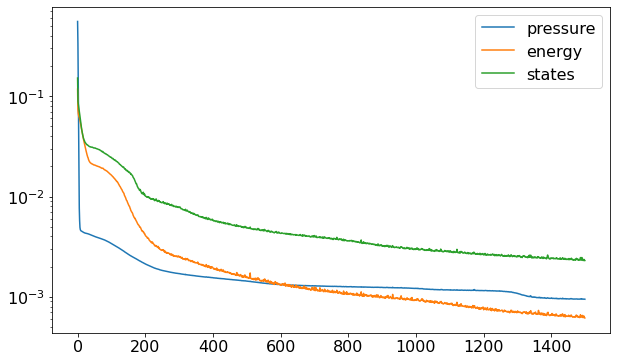

In [68]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['dstates_out_loss'], label='states')
plt.legend()

In [37]:
A_cluster = model.get_layer('pressure_out').get_weights()[0]

In [38]:
A_cluster

array([[-0.08 ,  0.069,  0.127, ...,  0.12 ,  0.048,  0.034],
       [ 0.003, -0.077, -0.088, ..., -0.046,  0.067,  0.066],
       [-0.034,  0.07 , -0.13 , ..., -0.071, -0.078, -0.026],
       ...,
       [-0.048,  0.069, -0.071, ..., -0.006, -0.026,  0.122],
       [-0.019, -0.016,  0.025, ...,  0.029, -0.033, -0.021],
       [ 0.153,  0.043,  0.099, ..., -0.003,  0.061,  0.057]], dtype=float32)

In [39]:
np.sum(np.abs(A_cluster)<1e-4)

7

In [40]:
np.prod(A_cluster.shape)

11640

# Validation data

In [42]:
file = './validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [43]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [44]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

<AxesSubplot:>

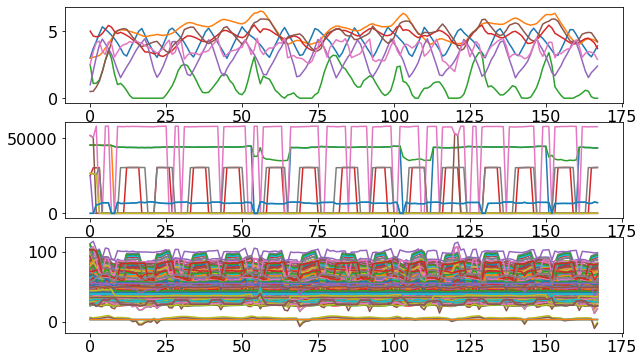

In [45]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

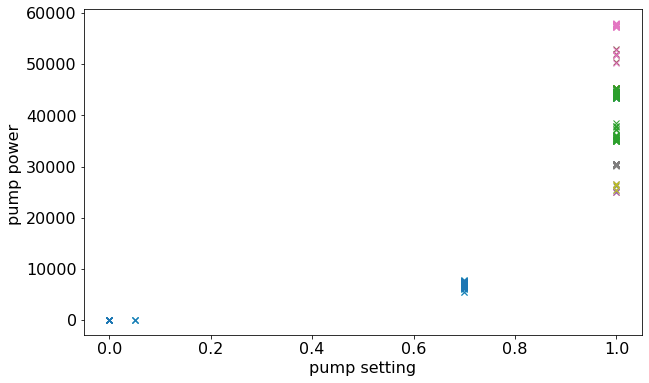

In [46]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [47]:
from IPython.display import clear_output, display

In [48]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

Open loop simulation of the Neural Network

In [69]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    #states_k_next = dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    #states_k_next = np.minimum(np.maximum(states_k_next,0),6)
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

est_pressure_df = pd.DataFrame(data=est_pressure, index=val_pressure.index[:-1], columns=val_pressure.keys())
est_energy_df = pd.DataFrame(data=est_energy, index=val_energy.index[:-1], columns=val_energy.keys())
est_states_df = pd.DataFrame(data=est_states, index=val_states.index, columns=val_states.keys())

166


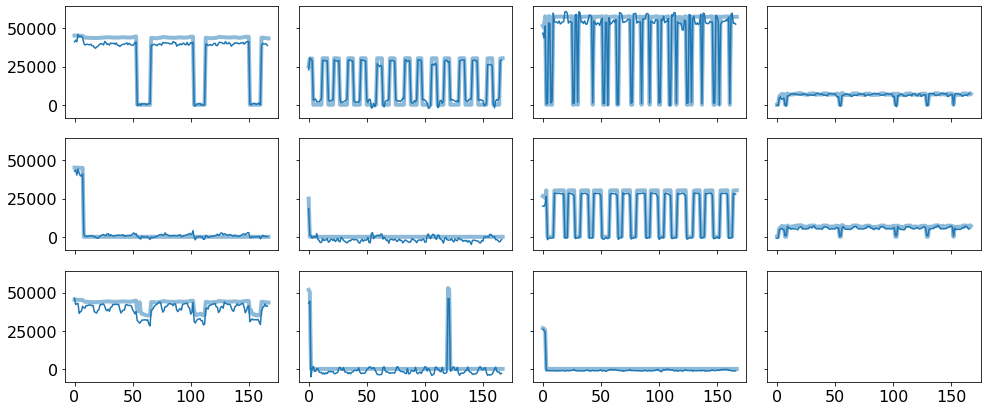

In [70]:
fig,ax = plt.subplots(3,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_energy.keys()):
    i,j = k%3,k//3
    
    val_energy[name].plot(legend=False, ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_energy_df[name].plot(legend=False, ax=ax[i,j])

fig.tight_layout()
    

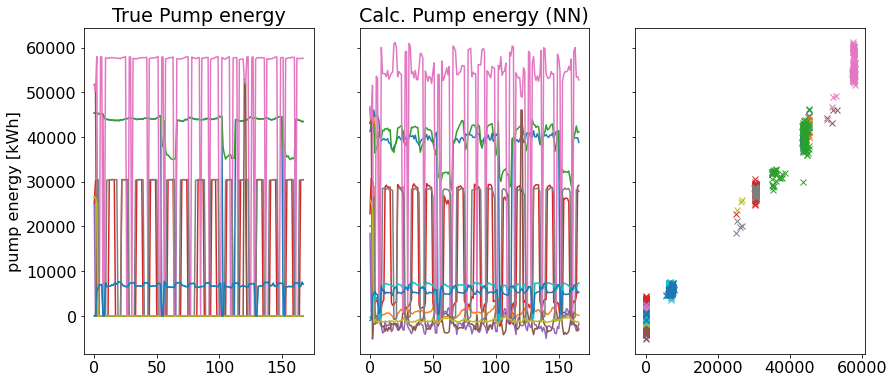

In [71]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')

plt.show()

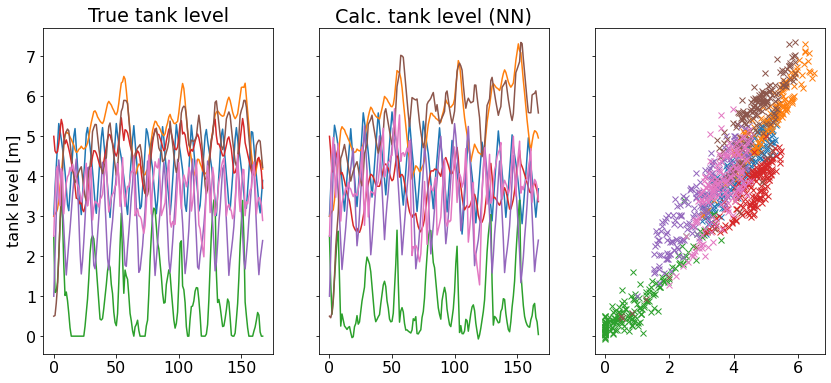

In [72]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')



plt.show()

In [75]:
est_states.shape

(168, 7)

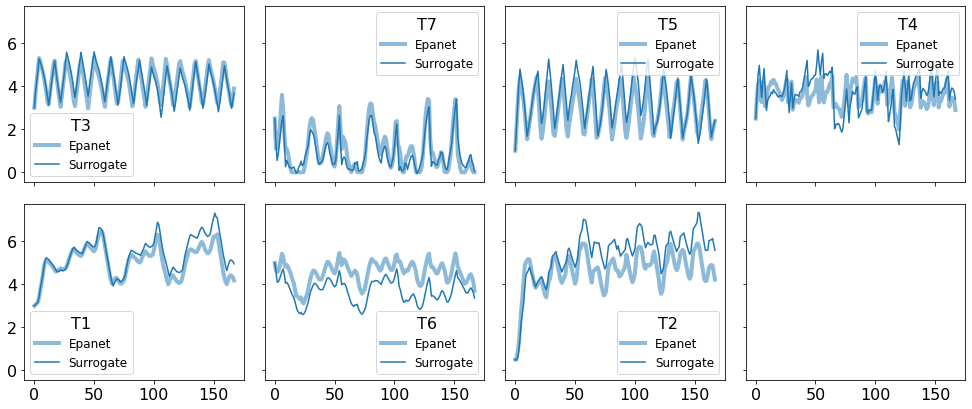

In [88]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_states.keys()):
    i,j = k%2,k//2
    
    val_states[name].plot(ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_states_df[name].plot(ax=ax[i,j])
    ax[i,j].legend(ax[i,j].lines,['Epanet','Surrogate'], title=name, fontsize=12)

fig.tight_layout()

In [84]:
ax[0,0].lines

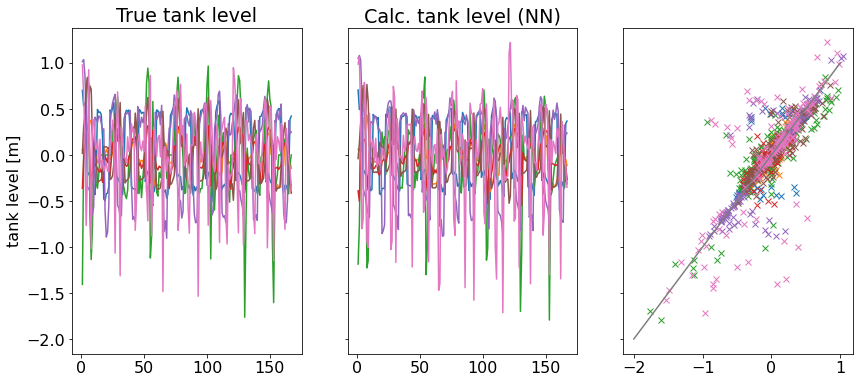

In [73]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.diff().plot(legend=False, ax=ax[0])
est_states_df.diff().plot(legend=False, ax=ax[1])
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states.diff(), est_states_df.diff(),'x')
ax[2].plot([-2,1],[-2,1])

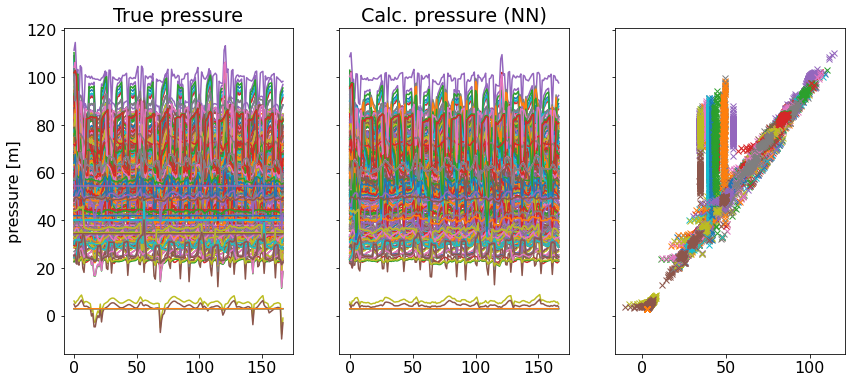

In [74]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()

Should we save the model?

In [89]:
model_name = '003'
model.save('./keras_models/{name}/{name}_model'.format(name=model_name))
scaling = {
    'input': input_scaling,
    'output': output_scaling
}

with open('./keras_models/{}/scaling.pkl'.format(model_name), 'wb') as f:
    pickle.dump(scaling, f)
    
history_export = history.history
history_export['epoch'] = history.epoch

with open('./keras_models/{}/history.pkl'.format(model_name), 'wb') as f:
    pickle.dump(history_export, f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_models/003/003_model/assets
